## **AG News Classification Dataset**


Group: The Spicy Anacondas

# Introduction & Data Exploration

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004.

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The file classes.txt contains a list of classes corresponding to each label.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".




In [ ]:
#importing necessary modules
import pandas as pd
import numpy as np
import re
import string as s

from termcolor import colored

#Train Test Split
from sklearn.model_selection import train_test_split

#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

#Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import SGDClassifier

Within this notebook our group will demonstrate how we have analysed the data, prepared it for processing, visualise the data, and apply / fit both machine learning and neural network model to compare the accuracy with regards to text classification. Our aim was to train and test the 127600 news articles total, and with the use of NLP tools, assign each article to a specific label based on its content. 

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus (World News, Sports News, Business News and Sci/Tech News). Each class contains exactly  30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

# Part 1. Machine Learning with Naïve Bayes and Linear SVC


* Transform text into numerical vector data using a pipeline
* Create a classifier
* Fit/train the classifier
* Test the classifier on new data
* Evaluate performance

Importing the training data in Pandas format for easier visualization, checking for nulls and whitespaces

Class column value:
1 = World News
2 = Sports News
3 = Business News
4 = Science/Technology News

In [ ]:
#import train data as pandas, assigning column names, trimming whitespace from ends of each value across all series in dataframe
def trim(dftrain):
    trim = lambda x: x.strip() if type(x) is str else x
    return dftrain.applymap(trim)
dftrain = trim(pd.read_csv('train.csv',header=None, names=['class','title','desc']))

In [ ]:
dftrain

,class,title,desc
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Pervez...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [ ]:
#quick check of sample news line
print(dftrain.desc[21000])

Made nervous by the announcement that McAfee #39;s (MFE:NYSE - news - research) CFO plans to resign, investors on Tuesday sold off shares of the antivirus maker.


Checking for whitespace

In [ ]:
blanks = []  # start with an empty list

# (index,label,review text)
for index,klas,title,desc in dftrain.itertuples():  # iterate over the DataFrame
    if type(desc)==str:            # avoid NaN values
        if desc.isspace():         # test 'review' for whitespace
            blanks.append(klas)     # add matching index numbers to the list
        
blanks

[]

Importing the testing data with the same procedure

In [ ]:
def trim(dftest):
    trim = lambda x: x.strip() if type(x) is str else x
    return dftest.applymap(trim)
dftest = trim(pd.read_csv('test.csv',header=None, names=['class','title','desc']))

In [ ]:
dftest

,class,title,desc
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [ ]:
blanks = []  # start with an empty list

# (index,label,review text)
for index,klas,title,desc in dftest.itertuples():  # iterate over the DataFrame
    if type(desc)==str:            # avoid NaN values
        if desc.isspace():         # test 'review' for whitespace
            blanks.append(klas)     # add matching index numbers to the list
        
blanks

[]

In [ ]:
#Final check for null values
dftrain.isnull().sum()

class    0
title    0
desc     0
dtype: int64

In [ ]:
dftest.isnull().sum()

class    0
title    0
desc     0
dtype: int64

Both the training and testing data have no null values or whitespaces. Quick check of data with .info() and labels with value_counts()

In [ ]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   class   120000 non-null  int64 
 1   title   120000 non-null  object
 2   desc    120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [ ]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   7600 non-null   int64 
 1   title   7600 non-null   object
 2   desc    7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB


In [ ]:
dftrain['class'].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: class, dtype: int64

In [ ]:
dftest['class'].value_counts()

3    1900
4    1900
2    1900
1    1900
Name: class, dtype: int64

Data visualization to see most frequent words appearing in 'Description' column of train set. We've noticed that words with capitalized letters are counted separately. There are also some presence of special characters

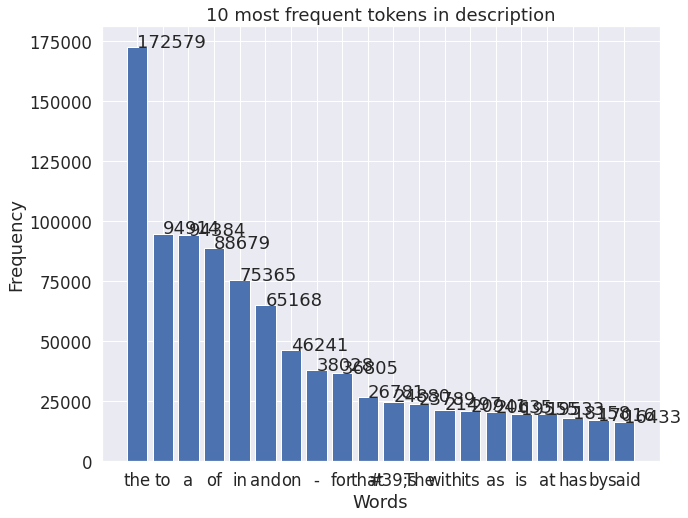

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def addlabels(words,counts):
    for i in range(len(words)):
        plt.text(i,counts[i],counts[i])

description_list = dftrain['desc'].values.tolist()

# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(" ".join(description_list).split()).most_common(20)

# `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]

figure(figsize = (10,8))
plt.bar(words, counts)
addlabels(words, counts)
plt.title("10 most frequent tokens in description")
plt.ylabel("Frequency")
plt.xlabel("Words")


plt.show()

Applying lower case characters for the Title and Description 

In [ ]:
dftest = dftest.applymap(lambda s:s.lower() if type(s) == str else s)
dftrain = dftrain.applymap(lambda s:s.lower() if type(s) == str else s)

## Build pipelines to vectorize the data, then train and fit a model

Next, data are already nicely split into training and testing. For efficiency purpose we are just going to use the 'Description' column as features for the machine learning part, and the news class column as target.

We develop a set of pipelines, running TfidfVectorizer with 1. Naïve Bayes 2. Linear SVC and 3. Stochastic Gradient Descent

In [ ]:
train_x=dftrain.desc
test_x=dftest.desc
train_y=dftrain['class']
test_y=dftest['class']

In [ ]:
test_x

0       unions representing workers at turner   newall...
1       space.com - toronto, canada -- a second\team o...
2       ap - a company founded by a chemistry research...
3       ap - it's barely dawn when mike fitzpatrick st...
4       ap - southern california's smog-fighting agenc...
                              ...                        
7595    ukrainian presidential candidate viktor yushch...
7596    with the supply of attractive pitching options...
7597    like roger clemens did almost exactly eight ye...
7598    singapore : doctors in the united states have ...
7599    ebay plans to buy the apartment and home renta...
Name: desc, Length: 7600, dtype: object

Model Pipeline

In [ ]:
# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])


#Stochastic Gradient Descent
SGD= Pipeline([('tfidf', TfidfVectorizer()),
                     ('sgd', SGDClassifier()),
])

text_clf_nb.fit(train_x, train_y)
text_clf_lsvc.fit(train_x, train_y)
SGD.fit(train_x,train_y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('sgd', SGDClassifier())])

In [ ]:
#running the prediction set
predictions = text_clf_nb.predict(test_x)

In [ ]:
#print confusion matrix & classification report
print(metrics.confusion_matrix(test_y,predictions))

[[1687   62  101   50]
 [  29 1845   11   15]
 [  71   21 1605  203]
 [  71   23  152 1654]]


In [ ]:
print(metrics.classification_report(test_y,predictions))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90      1900
           2       0.95      0.97      0.96      1900
           3       0.86      0.84      0.85      1900
           4       0.86      0.87      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



In [ ]:
print("Accuracy score using Naive Bayes is ", metrics.accuracy_score(test_y,predictions)*100, "%")

Accuracy score using Naive Bayes is  89.35526315789474 %


In [ ]:
svcpredictions = text_clf_lsvc.predict(test_x)
print("Accuracy score using Linear SVC is ", metrics.accuracy_score(test_y,svcpredictions)*100, "%")

Accuracy score using Linear SVC is  91.01315789473684 %


In [ ]:
sgdpredictions = SGD.predict(test_x)
print("Accuracy score using Linear SVC is ", metrics.accuracy_score(test_y,sgdpredictions)*100, "%")

Accuracy score using Linear SVC is  89.85526315789474 %


We have achieved slightly higher accuracy using Linear SVC. Let's visualize the confusion matrix of Linear SVC model

In [ ]:
import seaborn as sns
def confusion_mat(color):
    cof=confusion_matrix(test_y, svcpredictions)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

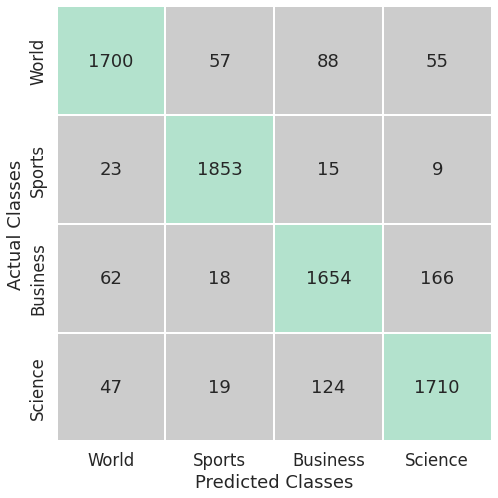

In [ ]:
confusion_mat('Pastel2_r')

Let's see if adding stop_words list from our previous frequent words visualization will improve the model

In [ ]:
#Instead of importing stopwords list, we create our own, using the most frequent words in training set
stopwords=['the','a','to','of','in','and','on','for','that', '#39;s','with','as','its','at','is','by','has','it']

In [ ]:
text_clf_lsvc2 = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                     ('clf', LinearSVC()),
])
text_clf_lsvc2.fit(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['39'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['the', 'a', 'to', 'of', 'in',
                                             'and', 'on', 'for', 'that',
                                             '#39;s', 'with', 'as', 'its', 'at',
                                             'is', 'by', 'has', 'it'])),
                ('clf', LinearSVC())])

In [ ]:
print(metrics.classification_report(test_y,predictions_with_stopwords))

              precision    recall  f1-score   support

           1       0.93      0.90      0.91      1900
           2       0.95      0.98      0.96      1900
           3       0.88      0.87      0.87      1900
           4       0.88      0.90      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [ ]:
print("Accuracy score using Linear SVC + stopwords list is ",metrics.accuracy_score(test_y,predictions_with_stopwords)*100, "%")

Accuracy score using Linear SVC + stopwords list is  90.96052631578947 %


The accuracy with adding stopwords actually decreased slightly. Based on our experience with TfidfVectorizer, Classification problems normally don’t need stop words because it’s possible to talk about the general idea of a text even if you remove stop words from it. ( https://medium.com/@limavallantin/why-is-removing-stop-words-not-always-a-good-idea-c8d35bd77214 )

Now let's feed some data to the Linear SVC + Tfidf Vectorizer prediction model

In [ ]:
test_desc = "Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."


In [ ]:
print(text_clf_lsvc2.predict([test_desc]))
#business - correct prediction

[3]


In [ ]:
dftrain.desc[20000]

'detroit (ticker) -- a rocky first inning was too much for denny bautista to overcome in his first major league start. craig monroe had an rbi single in a three-run first inning and added a solo homer off bautista'

In [ ]:
test_2 = 'detroit (ticker) -- a rocky first inning was too much for denny bautista to overcome in his first major league start. craig monroe had an rbi single in a three-run first inning and added a solo homer off bautista'

In [ ]:
print(text_clf_lsvc2.predict([test_2]))
#sports - correct prediction

[2]


# Part 2. Long Short-Term Memory (LSTM) Modelling

**BiDirectional LSTM**

We run our inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backwards we preserve information from the future and using the two hidden states combined we are able in any point in time to preserve information from both past and future.

In [ ]:
#Properly adding the right news labels
labels = {1:'World News', 2:'Sports News', 3:'Business News', 4:'Science-Technology News'}

dftrain['label'] = dftrain['class'].map(labels)
dftest['label'] = dftest['class'].map(labels)

In [ ]:
#Combine Title and Description
X_train = dftrain['title'] + " " + dftrain['desc'] # Combine title and description (better accuracy than using them as separate features)
y_train = dftrain['class'].apply(lambda x: x-1).values # Class labels need to begin from 0

x_test = dftest['title'] + " " + dftest['desc'] # Combine title and description (better accuracy than using them as separate features)
y_test = dftest['class'].apply(lambda x: x-1).values # Class labels need to begin from 0

#Max Length of sentences in Train Dataset
maxlen = X_train.map(lambda x: len(x.split())).max()

In [ ]:
#Quick check, now the title and description column is combined
X_train

0         wall st. bears claw back into the black (reute...
1         carlyle looks toward commercial aerospace (reu...
2         oil and economy cloud stocks' outlook (reuters...
3         iraq halts oil exports from main southern pipe...
4         oil prices soar to all-time record, posing new...
                                ...                        
119995    pakistan's musharraf says won't quit as army c...
119996    renteria signing a top-shelf deal red sox gene...
119997    saban not going to dolphins yet the miami dolp...
119998    today's nfl games pittsburgh at ny giants time...
119999    nets get carter from raptors indianapolis -- a...
Length: 120000, dtype: object

**Tokenizing Data**

According to vocabulary size

**Padding Data**

All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary.

In [ ]:
vocab_size = 10000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train.values)

# Tokenize data
X_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(x_test)

# Pad data
X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


We ended up with almost 1,5 million trainable params

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
model.add(Dense(1024))
model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 177, 32)           320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 177, 256)         164864    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 177, 128)         164352    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1024)              132096    
                                                      

In [ ]:
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )]

Running the model with 128 batch size and only 5 epochs, for time efficiency

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(X_train, 
          y_train, 
          batch_size=128, 
          validation_data=(x_test, y_test), 
          epochs=5, 
          callbacks=callbacks)

Epoch 1/5
938/938 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8743
Epoch 1: val_accuracy improved from -inf to 0.91039, saving model to weights.h5
938/938 [==============================] - 1538s 2s/step - loss: 0.3647 - accuracy: 0.8743 - val_loss: 0.2781 - val_accuracy: 0.9104
Epoch 2/5
938/938 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9226
Epoch 2: val_accuracy improved from 0.91039 to 0.91211, saving model to weights.h5
938/938 [==============================] - 1525s 2s/step - loss: 0.2381 - accuracy: 0.9226 - val_loss: 0.2609 - val_accuracy: 0.9121
Epoch 3/5
938/938 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9345
Epoch 3: val_accuracy improved from 0.91211 to 0.91684, saving model to weights.h5
938/938 [==============================] - 1523s 2s/step - loss: 0.1969 - accuracy: 0.9345 - val_loss: 0.2509 - val_accuracy: 0.9168
Epoch 4/5
938/938 [==============================] - ETA: 0s - loss: 0

In [ ]:
model.load_weights('weights.h5')
model.save('model.hdf5')

Visualizing news class prediction in clearer way (We even created our own news text)

In [ ]:
def modelDemo(news_text):

  #News Labels

  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
  
  test_seq = pad_sequences(tok.texts_to_sequences(news_text), maxlen=maxlen)

  test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

  for news, label in zip(news_text, test_preds):
      # print('{} - {}'.format(news, label))
      print('{} - {}'.format(colored(news, 'yellow'), colored(label, 'blue')))

In [ ]:
modelDemo(['New evidence of virus risks from wildlife trade'])

New evidence of virus risks from wildlife trade - Science-Technology News


In [ ]:
modelDemo(['Coronavirus: Bank pumps £100bn into UK economy to aid recovery'])


Coronavirus: Bank pumps £100bn into UK economy to aid recovery - Business News


In [ ]:
modelDemo(['ukrainian presidential candidate viktor yushchenko was poisoned with the most harmful known dioxin, which is contained in agent orange, a scientist who analyzed his blood said friday.'])


ukrainian presidential candidate viktor yushchenko was poisoned with the most harmful known dioxin, which is contained in agent orange, a scientist who analyzed his blood said friday. - World News


In [ ]:
modelDemo(['Huge victory: Cristiano Ronaldo scores hat-trick in decisive final'])


Huge victory: Cristiano Ronaldo scores hat-trick in decisive final - Sports News


In [ ]:
modelDemo(['Disease in scientific experiment gets wild'])


Disease in scientific experiment gets wild - Science-Technology News


In [ ]:
modelDemo(['My mom has discovered a new material that will get us to the moon'])

My mom has discovered a new material that will get us to the moon - Science-Technology News


Although the accuracy of the model is pretty much the same as ML Linear SVC model (91%), looking at this visualization matrix we can see the number of correctly predicted news class is higher, especially in the Business and Science News. 

<Figure size 432x288 with 0 Axes>

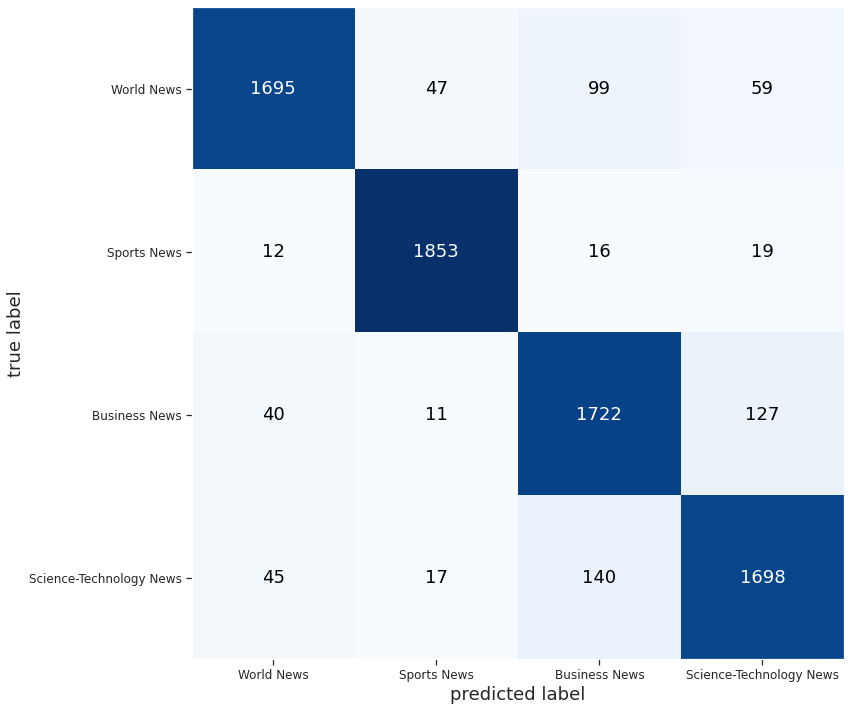

In [ ]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

In [ ]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))

Recall of the model is 0.92
Precision of the model is 0.92
Accuracy of the model is 0.92


# Conclusion

News Classification is very useful for news content management but also for audience segmentation and personalization, advertising / retargeting. Incorrectly predicted news class will result in content being irrelevant to audience, which is why accuracy is important in this dataset. Based on our experiment, the Bi-directional LSTM model has proven to improve the classification model. Further research to improve model would be to use higher number of epochs and batch size, and introduce other model such as BERT

Dataset Information & Knowledge Source:

http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html

https://github.com/nluninja/nlp_datasets/tree/main/ag_news/data

https://www.kaggle.com/code/amananandrai/news-article-classifier-with-different-models

https://github.com/nikenaml/news-classification-nlp-neural-network

https://www.tensorflow.org/datasets/catalog/ag_news_subset
